In [95]:
from imutils import face_utils
import numpy as np
import imutils
import cv2
import dlib
import collections
import matplotlib.pyplot as plt
%matplotlib inline  

In [96]:
# construct the argument parser and parse the arguments
shape_predictor = "shape_predictor_68_face_landmarks.dat"
happyimages = ["images/happy.png", "images/happy1.jpg", "images/happy2.jpg", "images/happy3.jpg", "images/happy4.jpg", "images/happy5.jpg", "images/happy6.jpg", "images/happy7.jpg"]
sadimages = ["images/sad.jpg", "images/sad1.jpg", "images/sad2.jpg", "images/sad3.png", "images/sad4.jpg", "images/sad5.jpg", "images/sad6.jpg", "images/sad7.jpg"]

In [97]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

In [98]:
 def readImage(image):  
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(image)
    image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)

    faceparts = dict()
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # loop over the face parts individually
        for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
            faceparts[name] = shape[i:j]
            # clone the original image so we can draw on it, then
            # display the name of the face part on the image
            clone = image.copy()
            cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 0, 255), 2)

            # loop over the subset of facial landmarks, drawing the
            # specific face part
            for (x, y) in shape[i:j]:
                cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)

            # extract the ROI of the face region as a separate image
#             (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
#             roi = image[y:y + h, x:x + w]
#             roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)

            #show the particular face part
#             cv2.imshow("ROI", roi)
#             cv2.imshow("Image", clone)
#             cv2.waitKey(0)
    return faceparts

In [101]:
def getSlope(partofmouth):
    mouthpoints = faceparts[partofmouth]
    corner1 = mouthpoints[0]
    corner2 = mouthpoints[0]
    for point in mouthpoints:
        if(point[0] < corner1[0]):
            corner1 = point
        if(point[0] > corner2[0]):
            corner2 = point
    middle = mouthpoints[0]
    middlenum = corner1[0] + (corner2[0]-corner1[0])/2
    distance = 100000000000000
    for point in mouthpoints:
        if(abs(point[0]-middlenum) <= (distance+7)):
            if(point[1] > middle[1]):
                middle = point 
                distance = abs(point[0]-middlenum)
    slope = (corner1[1]-middle[1])/(corner1[0]-middle[0])
    slope2 = (corner2[1]-middle[1])/(corner2[0]-middle[0])
    if(slope > 0):
        avgslope = (abs(slope)+abs(slope2))/2
    else: 
        avgslope = -1*(abs(slope)+abs(slope2))/2
    return avgslope

In [108]:
def getFlatSlope(partofmouth):
    mouthpoints = faceparts[partofmouth]
    corner1 = mouthpoints[0]
    corner2 = mouthpoints[0]
    for point in mouthpoints:
        if(point[0] < corner1[0]):
            corner1 = point
        if(point[0] > corner2[0]):
            corner2 = point
    middle = mouthpoints[0]
    middlenum = corner1[0] + (corner2[0]-corner1[0])/2
    distance = 100000000000000
    for point in mouthpoints:
        if(abs(point[0]-middlenum) <= (distance+7)):
            if(point[1] < middle[1]):
                middle = point 
                distance = abs(point[0]-middlenum)
    slope = (corner1[1]-middle[1])/(corner1[0]-middle[0])
    slope2 = (corner2[1]-middle[1])/(corner2[0]-middle[0])
    if(slope > 0):
        avgslope = (abs(slope)+abs(slope2))/2
    else: 
        avgslope = -1*(abs(slope)+abs(slope2))/2
    return avgslope

In [122]:
def getMouthValue(faceparts, image):
    mouthslope = getSlope('mouth')
    jawslope = getSlope('jaw')
    mouthsecondslope = getFlatSlope('mouth')
       
#     image = cv2.imread(image)
#     image = imutils.resize(image, width=500)
#     clone = image.copy()
#     cv2.putText(clone, "mouth", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
#                 0.7, (0, 0, 255), 2)

#     cv2.circle(clone, (corner1[0], corner1[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (corner2[0], corner2[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (middle[0], middle[1]), 1, (0, 0, 255), -1)

#     # show the particular face part
#     cv2.imshow("Image", clone)
#     cv2.waitKey(0)
    
    return mouthslope/(jawslope*mouthsecondslope)

In [123]:
def getEyeValue(faceparts, image):
    eyepoints = faceparts['right_eye']
    corner1 = eyepoints[0]
    corner2 = eyepoints[0]
    top = eyepoints[0]
    bottom = eyepoints[0]
    for point in eyepoints:
        if(point[0] < corner1[0]):
            corner1 = point
        if(point[0] > corner2[0]):
            corner2 = point
        if(point[1] < top[1]):
            top = point
        if(point[1] > bottom[1]):
            bottom = point
    ratio = (corner2[0]-corner1[0])/(bottom[1]-top[1])
    eyepoints = faceparts['left_eye']
    corner1 = eyepoints[0]
    corner2 = eyepoints[0]
    top = eyepoints[0]
    bottom = eyepoints[0]
    for point in eyepoints:
        if(point[0] < corner1[0]):
            corner1 = point
        if(point[0] > corner2[0]):
            corner2 = point
        if(point[1] < top[1]):
            top = point
        if(point[1] > bottom[1]):
            bottom = point
    ratio2 = (corner2[0]-corner1[0])/(bottom[1]-top[1])
    avgratio = (ratio+ratio2)/2
    
#     image = cv2.imread(image)
#     image = imutils.resize(image, width=500)
#     clone = image.copy()
#     cv2.putText(clone, "eye", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
#                 0.7, (0, 0, 255), 2)

#     cv2.circle(clone, (corner1[0], corner1[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (corner2[0], corner2[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (bottom[0], bottom[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (top[0], top[1]), 1, (0, 0, 255), -1)

#     # show the particular face part
#     cv2.imshow("Image", clone)
#     cv2.waitKey(0)
    
    return avgratio

In [124]:
happymouthvals = list()
happyeyevals = list()
for image in happyimages:
    faceparts = readImage(image)
    happymouthvals.append(getMouthValue(faceparts, image))
    happyeyevals.append(getEyeValue(faceparts, image))
print(happymouthvals)
print(happyeyevals)

[-4.147234737356803, -2.7551299731788848, -7.531396374822211, -2.3384526018483514, -3.6750750142968838, -2.8918637194138253, -5.507918346508329, -8.504001476048803]
[3.5595238095238093, 2.763157894736842, 2.5654761904761902, 5.416666666666666, 3.0888888888888886, 6.4375, 2.769230769230769, 2.6948529411764706]


In [125]:
sadmouthvals = list()
sadeyevals = list()
for image in sadimages:
    faceparts = readImage(image)
    sadmouthvals.append(getMouthValue(faceparts, image))
    sadeyevals.append(getEyeValue(faceparts, image))
print(sadmouthvals)
print(sadeyevals)

[-1.4901429056743198, -9.412565489347571, -3.802017885968128, -1.8159499740616631, -1.2977701202103795, -2.157298835350701, -0.9979980954726743, -1.241943963469594]
[2.916666666666667, 3.656200317965024, 2.8683397683397684, 3.2767857142857144, 4.615384615384615, 3.409090909090909, 2.2464285714285714, 3.036363636363636]


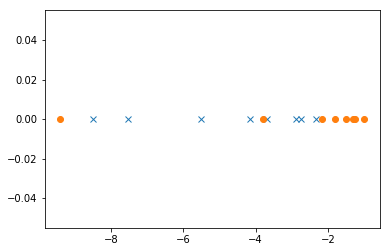

In [126]:
plt.plot(happymouthvals, np.zeros_like(happymouthvals) + 0, 'x')
plt.plot(sadmouthvals, np.zeros_like(sadmouthvals) + 0, 'o')

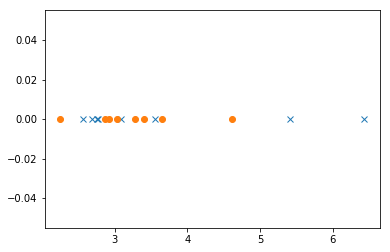

In [67]:
plt.plot(happyeyevals, np.zeros_like(happyeyevals) + 0, 'x')
plt.plot(sadeyevals, np.zeros_like(sadeyevals) + 0, 'o')

In [ ]:
# visualize all facial landmarks with a transparent overlay
output = face_utils.visualize_facial_landmarks(image, shape)
cv2.imshow("Image", output)
cv2.waitKey(0)

In [ ]:
clone = image.copy()
cv2.putText(clone, "mouth", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (0, 0, 255), 2)
 
cv2.circle(clone, (corner1[0], corner1[1]), 1, (0, 0, 255), -1)
cv2.circle(clone, (corner2[0], corner2[1]), 1, (0, 0, 255), -1)
cv2.circle(clone, (middle[0], middle[1]), 1, (0, 0, 255), -1)

# show the particular face part
cv2.imshow("Image", clone)
cv2.waitKey(0)

In [ ]:
def getMouthValue(faceparts, image):
    eyepoints = faceparts['mouth']
    corner1 = eyepoints[0]
    corner2 = eyepoints[0]
    top = eyepoints[0]
    bottom = eyepoints[0]
    for point in eyepoints:
        if(point[0] < corner1[0]):
            corner1 = point
        if(point[0] > corner2[0]):
            corner2 = point
        if(point[1] < top[1]):
            top = point
        if(point[1] > bottom[1]):
            bottom = point
    ratio = (corner2[0]-corner1[0])/(bottom[1]-top[1])
    
#     image = cv2.imread(image)
#     image = imutils.resize(image, width=500)
#     clone = image.copy()
#     cv2.putText(clone, "eye", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
#                 0.7, (0, 0, 255), 2)

#     cv2.circle(clone, (corner1[0], corner1[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (corner2[0], corner2[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (bottom[0], bottom[1]), 1, (0, 0, 255), -1)
#     cv2.circle(clone, (top[0], top[1]), 1, (0, 0, 255), -1)

#     # show the particular face part
#     cv2.imshow("Image", clone)
#     cv2.waitKey(0)
    
    return ratio